# SETTING UP

In [ ]:
%tensorflow_version 2.x
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping

# Helper libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, roc_auc_score, accuracy_score, roc_curve)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# A. DATA

## Load and merge data

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/newmm.csv')
mbs = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/mbs_person_summary.csv')
pbs = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/pbs_person_summary.csv')
drug = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/pbs_item_manufacturer.csv')
datambs = pd.merge(data, mbs.drop(['last_mbs', 'sex','yob','Unnamed: 0','ptnt_state', 'lastcontact'], axis = 1), left_on='pin', right_on='pin', how='left')
datambspbs = pd.merge(datambs, pbs.drop(['last_pbs', 'sex','yob','Unnamed: 0','nstate', 'lastcontact'], axis = 1), left_on='pin', right_on='pin', how='left')\
            .drop(['No', 'last_pbs', 'last_mbs', 'Concatenate', 'MMGrouping', 'Agegrouping', 'Lastservice', 'disDays'], axis =1)
datambspbs.head()

,pin,yob,sex,age,GroupingA10,GroupingC0,GroupingC10,dead,nrecords_x,firstcontact_x,nstate,totalfeecharged,totalschedfee,totalbenpaid,totalnumserv,lengthcontact_x,ptnt_state,nrecords_y,firstcontact_y,n_pbs_code,total_bnft_amt,total_ptnt_cntrbtn_amt,total_prscrptn_cnt,lengthcontact_y
0,7275102840,1924,M,80,A10,C0,No,YES,118.0,1984-05-16,1.0,256930.0,287000.0,"$252,645.00",99.0,9951.0,VIC,80,2004-06-01,11,1955.97,384.60,80,2630
1,316560614,1925,F,79,No,C0,No,NO,778.0,1984-03-29,1.0,4356900.0,3690900.0,"$3,199,140.00",656.0,11233.0,VIC,325,2003-01-15,46,7112.05,1633.76,325,4367
2,1706657926,1919,F,85,No,C0,No,YES,304.0,1984-03-24,2.0,609220.0,714360.0,"$607,930.00",304.0,6898.0,QLD,3,2003-08-15,3,92.60,12.10,3,701
3,9352250463,1971,F,33,No,C0,No,NO,1548.0,1984-10-05,2.0,4990480.0,4982320.0,"$4,457,090.00",1255.0,11043.0,SA,1296,2003-01-02,74,31417.87,4149.50,1296,4380
4,6529626350,1944,F,60,No,C0,No,NO,250.0,1986-10-22,1.0,713230.0,743615.0,"$661,975.00",193.0,10251.0,NSW,414,2003-03-18,17,13493.79,1413.00,414,4304


## Pre-processing

In [ ]:
df = pd.DataFrame(datambspbs)

# Drop all records with NA
df.dropna(inplace=True)

# Create firstcontactage features
df[['firstcontact_x','firstcontact_y']] = pd.to_datetime(df[['firstcontact_x','firstcontact_y']].stack(), format = '%Y-%m-%d').unstack()
df['firstcontact_x'] = pd.DatetimeIndex(df['firstcontact_x']).year
df['firstcontactage_x'] = df['firstcontact_x'] - df['yob']
df['firstcontact_y'] = pd.DatetimeIndex(df['firstcontact_y']).year
df['firstcontactage_y'] = df['firstcontact_y'] - df['yob']

# Write csv file
df.to_csv(r'/content/drive/My Drive/Medicare Analysis/Data/aggdata.csv', index = False, header=True)

# Drop yob and firstcontact features
df.drop(['firstcontact_x', 'firstcontact_y', 'yob', 'pin'], axis = 1, inplace=True)

# Redefine feature type
df[['nrecords_x']] = df[['nrecords_x']].astype('int64')

# Encoding categorical features
df = pd.get_dummies(df, columns = ['ptnt_state'])
df['totalbenpaid'] = df['totalbenpaid'].replace('[\$,]', '', regex=True).astype(float)
df['sex'] = df['sex'].replace({'F':1, 'M':0}).astype('uint8')
df['GroupingA10'] = df['GroupingA10'].replace({'A10':1, 'No':0}).astype('uint8')
df['GroupingC0'] = df['GroupingC0'].replace({'C0':1, 'No':0}).astype('uint8')
df['GroupingC10'] = df['GroupingC10'].replace({'C10':1, 'No':0}).astype('uint8')
df['dead'] = df['dead'].replace({'YES':1, 'NO':0}).astype('uint8')

# Shape of the final dataset
print("df.shape:", df.shape)
df.head()

df.shape: (346182, 27)


,sex,age,GroupingA10,GroupingC0,GroupingC10,dead,nrecords_x,nstate,totalfeecharged,totalschedfee,totalbenpaid,totalnumserv,lengthcontact_x,nrecords_y,n_pbs_code,total_bnft_amt,total_ptnt_cntrbtn_amt,total_prscrptn_cnt,lengthcontact_y,firstcontactage_x,firstcontactage_y,ptnt_state_NSW,ptnt_state_QLD,ptnt_state_SA,ptnt_state_UNK,ptnt_state_VIC,ptnt_state_WA
0,0,80,1,1,0,1,118,1.0,256930.0,287000.0,252645.0,99.0,9951.0,80,11,1955.97,384.60,80,2630,60,80,0,0,0,0,1,0
1,1,79,0,1,0,0,778,1.0,4356900.0,3690900.0,3199140.0,656.0,11233.0,325,46,7112.05,1633.76,325,4367,59,78,0,0,0,0,1,0
2,1,85,0,1,0,1,304,2.0,609220.0,714360.0,607930.0,304.0,6898.0,3,3,92.60,12.10,3,701,65,84,0,1,0,0,0,0
3,1,33,0,1,0,0,1548,2.0,4990480.0,4982320.0,4457090.0,1255.0,11043.0,1296,74,31417.87,4149.50,1296,4380,13,32,0,0,1,0,0,0
4,1,60,0,1,0,0,250,1.0,713230.0,743615.0,661975.0,193.0,10251.0,414,17,13493.79,1413.00,414,4304,42,59,1,0,0,0,0,0


## Class imbalance

Examples:
    Total: 346182
    Positive: 93164 (26.91% of total)



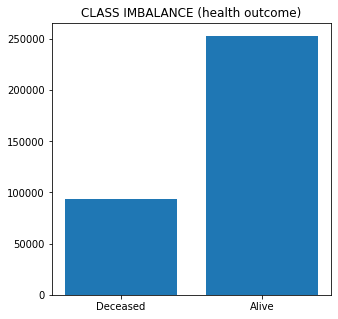

In [ ]:
# Class imbalance problem
neg, pos = np.bincount(df['dead'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
plt.figure(figsize=(5,5))
plt.bar(['Deceased', 'Alive'], height=[pos, neg])
plt.title('CLASS IMBALANCE (health outcome)')
plt.show()

In [ ]:
# # import warnings filter
# from warnings import simplefilter
# # ignore all future warnings
# simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

# B. MACHINE LEARNING CLASSIFIERS

## Prepare train-test set

In [ ]:
#split train and test sets
train, test = train_test_split(df, test_size=0.1, stratify = df['dead'])

ytrain = np.array(train.pop('dead'))
bool_train_labels = ytrain != 0
ytest = np.array(test.pop('dead'))

xtrain = np.array(train)
xtest = np.array(test)

print("xtrain.shape:", xtrain.shape, ", ytrain.shape:", ytrain.shape)
print("xtest.shape:", xtest.shape, ", ytest.shape:", ytest.shape)

xtrain.shape: (311563, 26) , ytrain.shape: (311563,)
xtest.shape: (34619, 26) , ytest.shape: (34619,)


## Grid Search

In [ ]:
classifiers=[LogisticRegression(), GaussianNB(), DecisionTreeClassifier(),
             RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(),
             ExtraTreesClassifier(), KNeighborsClassifier()]    

model_names = ['LogisticRegression','GaussianNB','DecisionTreeClassifier',
               'RandomForestClassifier','GradientBoostingClassifier', 'AdaBoostClassifier',
               'ExtraTreesClassifier', 'KNeighborsClassifier']

In [ ]:
def grid_search(clf, params):
  scaler = StandardScaler()

  # Build grid
  rs = GridSearchCV(clf, params, cv=3, scoring= 'accuracy')

  # Fit data
  rs.fit(scaler.fit_transform(xtrain)[:35000], ytrain[:35000])

  # Best model
  best_model = rs.best_estimator_

  # Predict on test set
  ypred = best_model.predict(xtest)
  yprob = best_model.predict_proba(xtest)[:,1]

  # Print best model
  print(best_model)

  # Metrics
  print("\tPrecision: %1.3f" % precision_score(ytest, ypred))
  print("\tROC (AUC): %1.3f" % roc_auc_score(ytest, ypred))
  print("\tRecall: %1.3f" % recall_score(ytest, ypred))
  print("\tF1: %1.3f" % f1_score(ytest, ypred))
  print("\tAccuracy: %1.3f" % accuracy_score(ytest, ypred))
  print("\tBrier: %1.3f" % brier_score_loss(ytest, yprob))

### Logistic Regression

In [ ]:
params = {
    'penalty': ['elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

grid_search(classifiers[0], params)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
	Precision: 0.000
	ROC (AUC): 0.500
	Recall: 0.000
	F1: 0.000
	Accuracy: 0.731
	Brier: 0.269


### Random Forest Classifier

In [ ]:
params = {
    'n_estimators': [50, 100, 150, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None]
    }

grid_search(classifiers[3], params)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
	Precision: 1.000
	ROC (AUC): 0.500
	Recall: 0.000
	F1: 0.000
	Accuracy: 0.731
	Brier: 0.221


### Extra Trees Classifier

In [ ]:
params = {
    'n_estimators': [50, 100, 150, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None]
    }

grid_search(classifiers[6], params)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
	Precision: 0.886
	ROC (AUC): 0.502
	Recall: 0.003
	F1: 0.007
	Accuracy: 0.732
	Brier: 0.215


### Gradient Boosting Classifier

In [ ]:
params = {
    'n_estimators': [50, 100, 150, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'learning_rate': [0.01, 0.1]
    }

grid_search(classifiers[4], params)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
	Precision: 1.000
	ROC (AUC): 0.500
	Recall: 0.001
	F1: 0.001
	Accuracy: 0.731
	Brier: 0.269


## Model fitting

In [ ]:
classifiers=[LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False),
             RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False),
             ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False),
             GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)]
model_names = ['LogisticRegression', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier']

In [ ]:
def plot_results(clf, name):

    # Build pipeline with SMOTE upsampling to deal with class imbalance
    pipeline = make_pipeline(StandardScaler(), SMOTE(random_state=42), clf)

    # Fit data
    pipeline.fit(xtrain, ytrain)
    
    # Save the model
    filename = f'/content/drive/My Drive/Medicare Analysis/Data/model/{name}.sav'
    joblib.dump(pipeline, filename)
    
    # Load the model again
    model = joblib.load(filename)

    # Predict on test set
    ypred = model.predict(xtest)
    yprob = model.predict_proba(xtest)[:,1]
    
    # Print metrics results
    print("%s:" % name)
    print("\tPrecision: %1.3f" % precision_score(ytest, ypred))
    print("\tROC (AUC): %1.3f" % roc_auc_score(ytest, ypred))
    print("\tRecall: %1.3f" % recall_score(ytest, ypred))
    print("\tF1: %1.3f" % f1_score(ytest, ypred))
    print("\tAccuracy: %1.3f" % accuracy_score(ytest, ypred))
    print("\tBrier: %1.3f" % brier_score_loss(ytest, yprob))

    # Plot confusion matrix
    p = 0.5
    cm = confusion_matrix(ytest, ypred > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    plt.show()
    
    # Plot ROC curve
    fp, tp, _ = roc_curve(ytest, yprob)
    fig = plt.figure(figsize=(5, 5))
    plt.plot(100*fp, 100*tp, label=name, linewidth=2)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.show()
    
    # Plot calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(ytest, yprob, n_bins=10)
    
    fig = plt.figure(figsize=(5, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name))
    ax2.hist(yprob, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    plt.tight_layout()

### Logistic Regression


LogisticRegression:
	Precision: 0.972
	ROC (AUC): 0.974
	Recall: 0.957
	F1: 0.965
	Accuracy: 0.981
	Brier: 0.016
Legitimate Transactions Detected (True Negatives):  25048
Legitimate Transactions Incorrectly Detected (False Positives):  254
Fraudulent Transactions Missed (False Negatives):  398
Fraudulent Transactions Detected (True Positives):  8919
Total Fraudulent Transactions:  9317


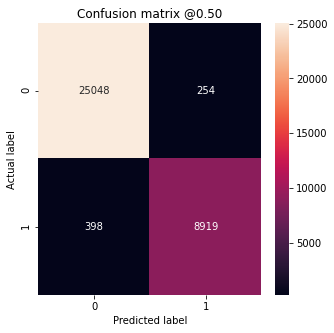

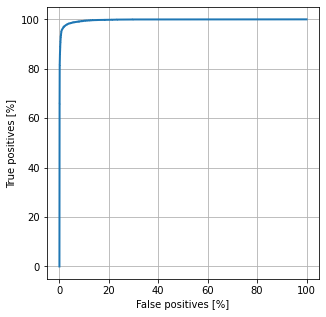

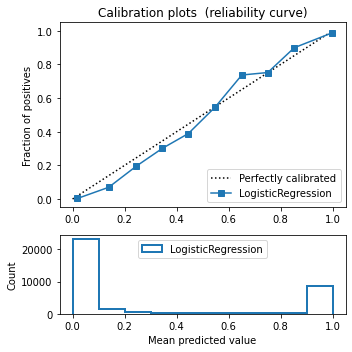

In [ ]:
# Best model from grid search
plot_results(classifiers[0], model_names[0])
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig8-1.pdf')
plt.show()

In [ ]:
# Fit a Logistic Regression classifier without SMOTE
plot_results(classifiers[0], model_names[0])
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression:
	Precision: 0.973
	ROC (AUC): 0.974
	Recall: 0.959
	F1: 0.966
	Accuracy: 0.982
	Brier: 0.015
Legitimate Transactions Detected (True Negatives):  25054
Legitimate Transactions Incorrectly Detected (False Positives):  248
Fraudulent Transactions Missed (False Negatives):  384
Fraudulent Transactions Detected (True Positives):  8933
Total Fraudulent Transactions:  9317


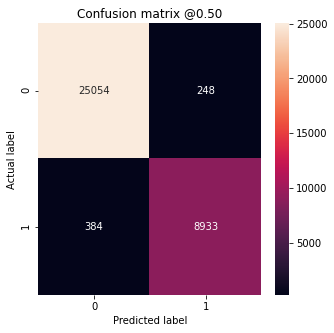

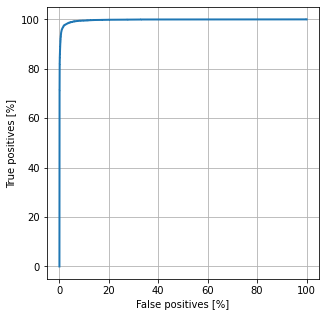

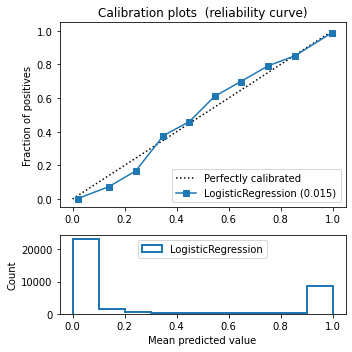

In [ ]:
# Fit a Logistic Regression classifier with SMOTE
plot_results(classifiers[0], model_names[0])
plt.show()

### Random Forest Classifier

RandomForestClassifier:
	Precision: 0.964
	ROC (AUC): 0.980
	Recall: 0.973
	F1: 0.968
	Accuracy: 0.983
	Brier: 0.013
Legitimate Transactions Detected (True Negatives):  24961
Legitimate Transactions Incorrectly Detected (False Positives):  341
Fraudulent Transactions Missed (False Negatives):  249
Fraudulent Transactions Detected (True Positives):  9068
Total Fraudulent Transactions:  9317


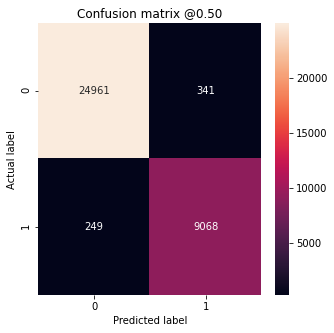

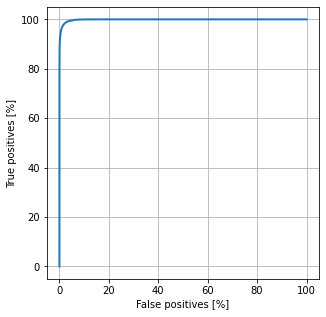

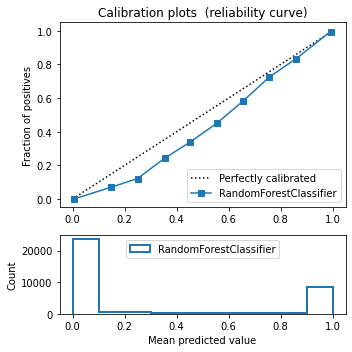

In [ ]:
# Best model from grid search
plot_results(classifiers[3], model_names[3])
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig8-2.pdf')
plt.show()

RandomForestClassifier:
	Precision: 0.968
	ROC (AUC): 0.980
	Recall: 0.973
	F1: 0.970
	Accuracy: 0.984
	Brier: 0.012
Legitimate Transactions Detected (True Negatives):  24998
Legitimate Transactions Incorrectly Detected (False Positives):  304
Fraudulent Transactions Missed (False Negatives):  254
Fraudulent Transactions Detected (True Positives):  9063
Total Fraudulent Transactions:  9317


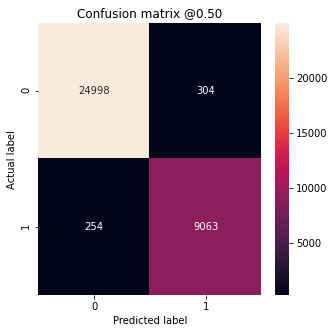

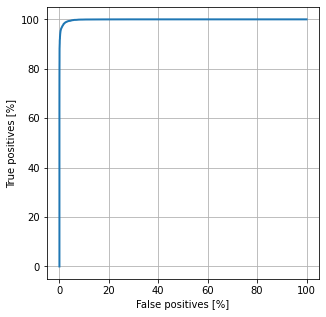

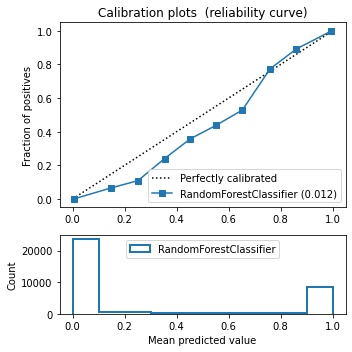

In [ ]:
# Fit a Random Forest Classifier
plot_results(classifiers[3], model_names[3])
plt.show()

### Extra Trees Classifier

ExtraTreesClassifier:
	Precision: 0.970
	ROC (AUC): 0.972
	Recall: 0.956
	F1: 0.963
	Accuracy: 0.980
	Brier: 0.016
Legitimate Transactions Detected (True Negatives):  25022
Legitimate Transactions Incorrectly Detected (False Positives):  280
Fraudulent Transactions Missed (False Negatives):  413
Fraudulent Transactions Detected (True Positives):  8904
Total Fraudulent Transactions:  9317


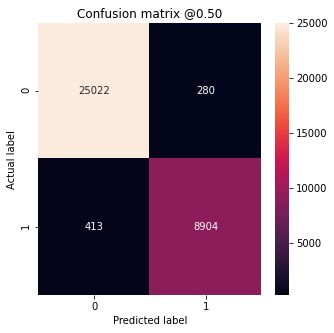

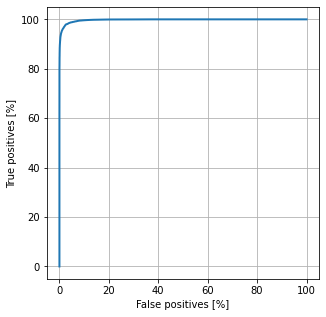

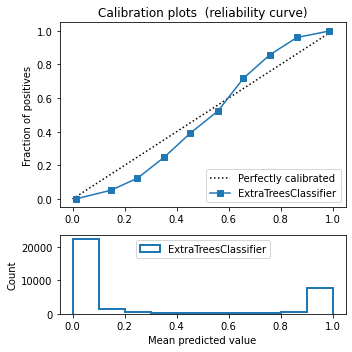

In [ ]:
# Best model from grid search
plot_results(classifiers[6], model_names[6])
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig8-3.pdf')
plt.show()

ExtraTreesClassifier:
	Precision: 0.971
	ROC (AUC): 0.974
	Recall: 0.958
	F1: 0.965
	Accuracy: 0.981
	Brier: 0.016
Legitimate Transactions Detected (True Negatives):  25038
Legitimate Transactions Incorrectly Detected (False Positives):  264
Fraudulent Transactions Missed (False Negatives):  388
Fraudulent Transactions Detected (True Positives):  8929
Total Fraudulent Transactions:  9317


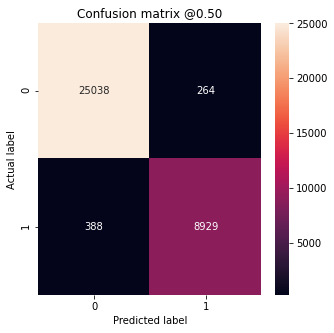

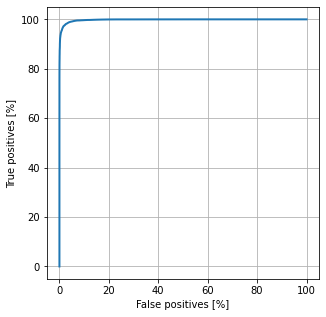

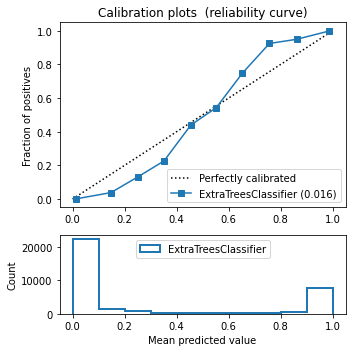

In [ ]:
# Fit an Extra Trees Classifier
plot_results(classifiers[6], model_names[6])
plt.show()

### Gradient Boosting Classifier

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


GradientBoostingClassifier:
	Precision: 0.975
	ROC (AUC): 0.984
	Recall: 0.976
	F1: 0.976
	Accuracy: 0.987
	Brier: 0.010
Legitimate Transactions Detected (True Negatives):  25069
Legitimate Transactions Incorrectly Detected (False Positives):  233
Fraudulent Transactions Missed (False Negatives):  219
Fraudulent Transactions Detected (True Positives):  9098
Total Fraudulent Transactions:  9317


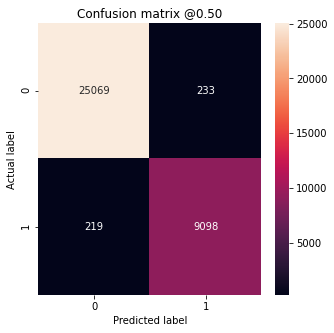

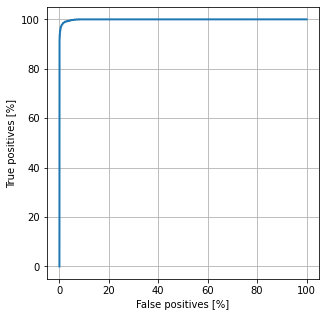

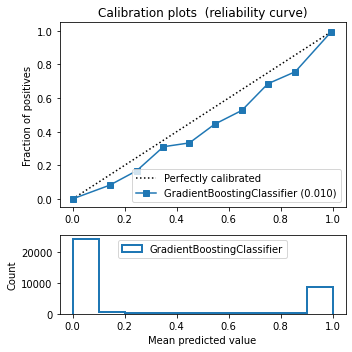

In [ ]:
# Best model from grid search
plot_results(classifiers[3], model_names[3])
plt.show()

GradientBoostingClassifier:
	Precision: 0.951
	ROC (AUC): 0.980
	Recall: 0.979
	F1: 0.965
	Accuracy: 0.981
	Brier: 0.014
Legitimate Transactions Detected (True Negatives):  24836
Legitimate Transactions Incorrectly Detected (False Positives):  466
Fraudulent Transactions Missed (False Negatives):  195
Fraudulent Transactions Detected (True Positives):  9122
Total Fraudulent Transactions:  9317


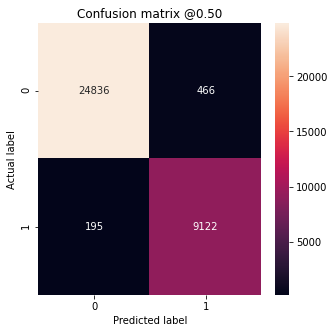

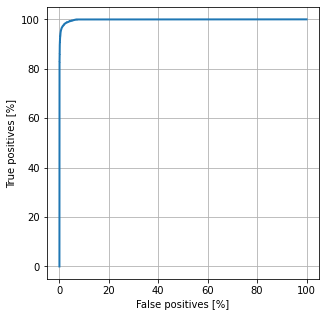

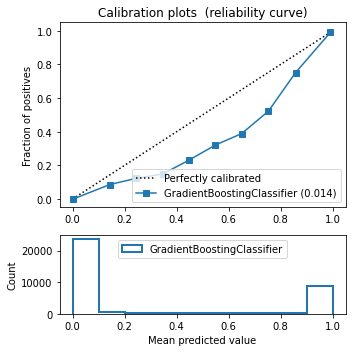

In [ ]:
# Fit a Gradient Boosting Classifier
plot_results(classifiers[4], model_names[4])
plt.show()

### Gaussian Naive Bayes

GaussianNB:
	Precision: 0.831
	ROC (AUC): 0.910
	Recall: 0.887
	F1: 0.858
	Accuracy: 0.921
	Brier: 0.066
Legitimate Transactions Detected (True Negatives):  23622
Legitimate Transactions Incorrectly Detected (False Positives):  1680
Fraudulent Transactions Missed (False Negatives):  1054
Fraudulent Transactions Detected (True Positives):  8263
Total Fraudulent Transactions:  9317


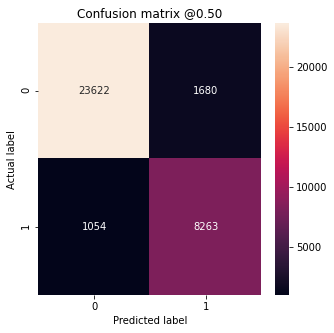

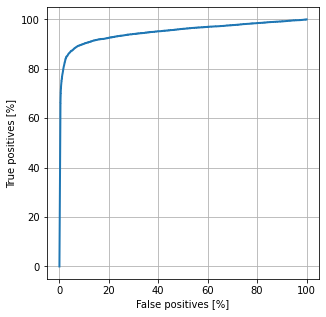

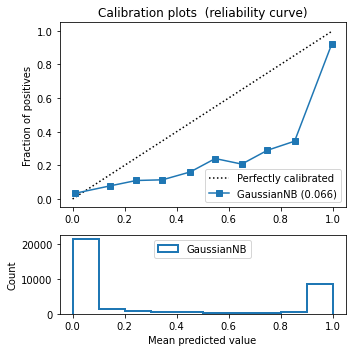

In [ ]:
# Fit a Gaussian Naive Bayes classifier
plot_results(classifiers[1], model_names[1])
plt.show()

### Decision Tree Classifier

DecisionTreeClassifier:
	Precision: 0.946
	ROC (AUC): 0.972
	Recall: 0.964
	F1: 0.955
	Accuracy: 0.976
	Brier: 0.024
Legitimate Transactions Detected (True Negatives):  24794
Legitimate Transactions Incorrectly Detected (False Positives):  508
Fraudulent Transactions Missed (False Negatives):  331
Fraudulent Transactions Detected (True Positives):  8986
Total Fraudulent Transactions:  9317


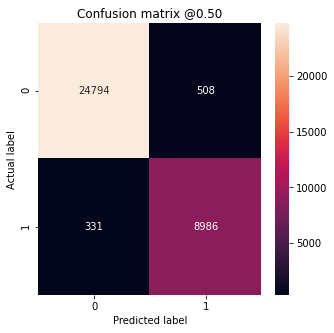

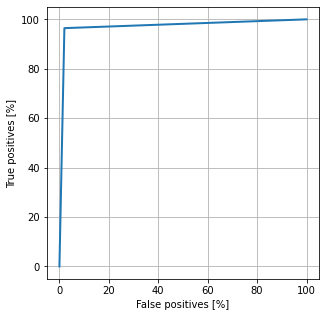

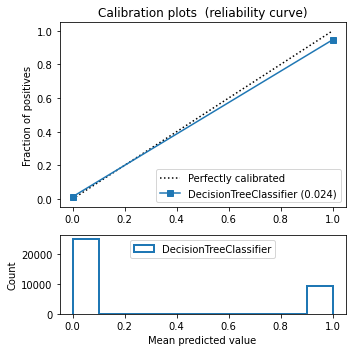

In [ ]:
# Fit a Decision Tree Classifier
plot_results(classifiers[2], model_names[2])
plt.show()

### AdaBoost Classifier

AdaBoostClassifier:
	Precision: 0.937
	ROC (AUC): 0.978
	Recall: 0.981
	F1: 0.959
	Accuracy: 0.977
	Brier: 0.121
Legitimate Transactions Detected (True Negatives):  24692
Legitimate Transactions Incorrectly Detected (False Positives):  610
Fraudulent Transactions Missed (False Negatives):  180
Fraudulent Transactions Detected (True Positives):  9137
Total Fraudulent Transactions:  9317


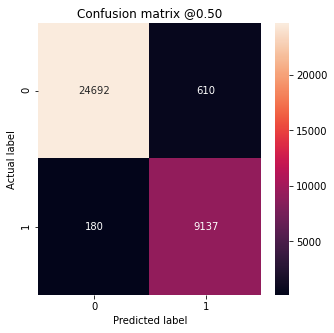

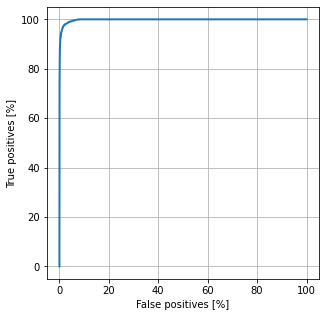

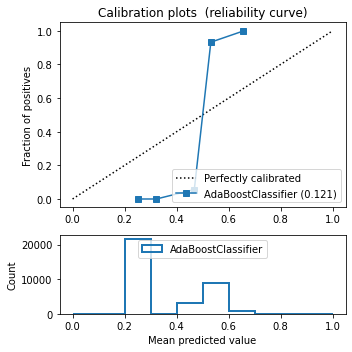

In [ ]:
# Fit a AdaBoost Classifier
plot_results(classifiers[5], model_names[5])
plt.show()

### KNeighbors Classifier

KNeighborsClassifier:
	Precision: 0.868
	ROC (AUC): 0.920
	Recall: 0.889
	F1: 0.879
	Accuracy: 0.934
	Brier: 0.051
Legitimate Transactions Detected (True Negatives):  24047
Legitimate Transactions Incorrectly Detected (False Positives):  1255
Fraudulent Transactions Missed (False Negatives):  1030
Fraudulent Transactions Detected (True Positives):  8287
Total Fraudulent Transactions:  9317


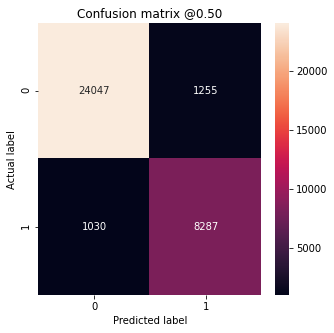

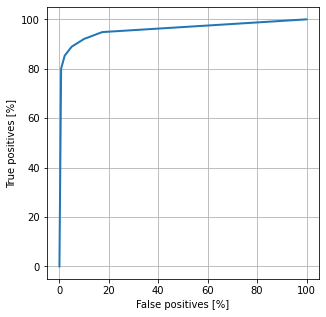

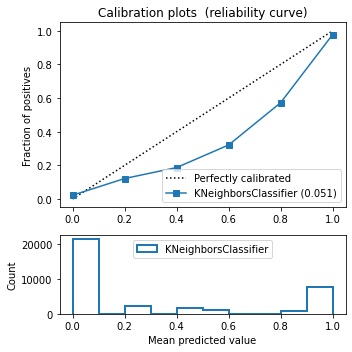

In [ ]:
# Fit a KNeighbors Classifier
plot_results(classifiers[7], model_names[7])
plt.show()

# C. NEURAL NETWORKS

## Prepare train-test set

In [ ]:
#split train and test sets
trainval, test = train_test_split(df, test_size=0.1, stratify = df['dead'])

#split train and validation sets
train, val = train_test_split(trainval, test_size=0.1, stratify = trainval['dead'])

ytrain = np.array(train.pop('dead'))
bool_train_labels = ytrain != 0
yval = np.array(val.pop('dead'))
ytest = np.array(test.pop('dead'))

xtrain = np.array(train)
xval = np.array(val)
xtest = np.array(test)

print("xtrain.shape:", xtrain.shape, ", ytrain.shape:", ytrain.shape)
print("xvalid.shape:", xval.shape, ", yvalid.shape:", yval.shape)
print("xtest.shape:", xtest.shape, ", ytest.shape:", ytest.shape)

# Upsampling
smote = SMOTE()
xtrain, ytrain = smote.fit_resample(xtrain, ytrain)

# Standardization
scaler = StandardScaler()

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((scaler.fit_transform(xtrain), ytrain))
val_set = tf.data.Dataset.from_tensor_slices((scaler.transform(xval), yval))
test_set = tf.data.Dataset.from_tensor_slices((scaler.transform(xtest), ytest))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
val_batches = val_set.shuffle(buffer_size=1024).batch(batch_size)
test_batches = test_set.batch(batch_size)

xtrain.shape: (280406, 26) , ytrain.shape: (280406,)
xvalid.shape: (31157, 26) , yvalid.shape: (31157,)
xtest.shape: (34619, 26) , ytest.shape: (34619,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Model construction

In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn')
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          128, activation='relu', 
          kernel_initializer=tf.keras.initializers.he_uniform(seed=0),
          input_shape=(xtrain.shape[-1],)),
      # keras.layers.Dense(
      #     128, activation='relu', 
      #     kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      keras.layers.Dense(
          64, activation='relu', 
          kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      # keras.layers.Dense(
      #     32, activation='relu', 
      #     kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      keras.layers.Dense(
          32, activation='relu', 
          kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.SGD(decay=1e-3),
      loss=keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=metrics)

  return model

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 3, n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(labels, probabilities):
  fp, tp, _ = roc_curve(labels, probabilities)
  plt.figure(figsize=(5,5))
  plt.plot(100*fp, 100*tp, linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def plot_calibration_curve(labels, probabilities):
  fig = plt.figure(figsize=(5,5))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))
  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

  fraction_of_positives, mean_predicted_value = calibration_curve(labels, probabilities, n_bins=10)

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-")

  ax2.hist(probabilities, range=(0, 1), bins=10, histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  # ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots (reliability curve)')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  # ax2.legend(loc="upper center", ncol=2)

  plt.tight_layout()
  plt.show()

In [ ]:
EPOCHS = 2000

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10,
    mode='max',
    restore_best_weights=True)

# Fix initial bias to save model from first few epochs learning positive examples are unlikely (class imbalance)
initial_bias = np.log([pos/neg])
model = make_model(output_bias = initial_bias)
model.summary()

# Save initial weights for fair comparison
initial_weights = '/content/drive/My Drive/Medicare Analysis/Data/model/initial weights/'
model.save_weights(initial_weights)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               3456      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 13,825
Trainable params: 13,825
Non-trainable params: 0
_________________________________________________________________


### Baseline model

In [ ]:
# Fit model with SMOTE
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches,
    verbose=0,
    callbacks = [early_stopping])

# Save model
baseline_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN baseline/'
model.save_weights(baseline_savepath)

loss :  0.0991891399025917
accuracy :  0.9688729643821716
precision :  0.9414350986480713
recall :  0.9430030584335327
auc :  0.9918796420097351
tp :  25479.0
fp :  1585.0
tn :  71791.0
fn :  1540.0
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
brier: 0.025
ROC (AUC): 0.96052
Legitimate Transactions Detected (True Negatives):  24749
Legitimate Transactions Incorrectly Detected (False Positives):  553
Fraudulent Transactions Missed (False Negatives):  532
Fraudulent Transactions Detected (True Positives):  8785
Total Fraudulent Transactions:  9317


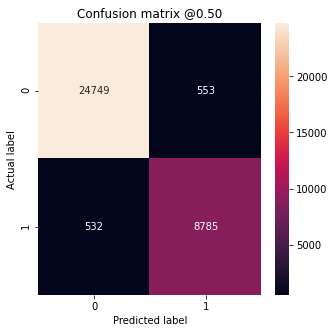

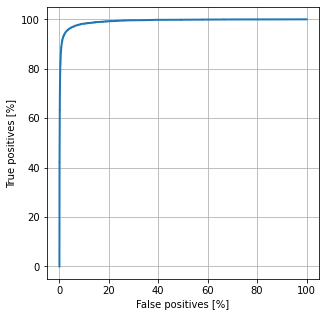

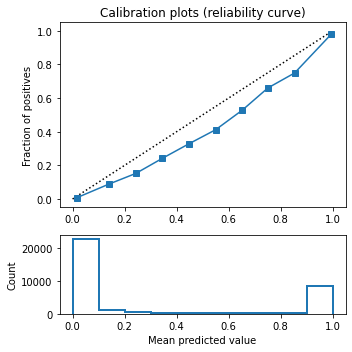

In [ ]:
# Load model again
model = make_model()
model.load_weights(baseline_savepath)

# Plot results
# plot_metrics(baseline_history)

baseline_results = model.evaluate(test_batches, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

train_predictions_baseline = model.predict_classes(train_batches)
test_predictions_baseline = model.predict_classes(test_batches)
test_probabilities_baseline = model.predict(test_batches)
brier_score = brier_score_loss(ytest, test_probabilities_baseline)
print("brier: %1.3f" % (brier_score))
print("ROC (AUC): %1.5f" % roc_auc_score(ytest, test_predictions_baseline))

plot_cm(ytest, test_predictions_baseline)
plt.show()

plot_roc(ytest, test_probabilities_baseline)
plt.show()

plot_calibration_curve(ytest, test_probabilities_baseline)

loss :  0.0864349976181984
accuracy :  0.9703083038330078
precision :  0.9675791263580322
recall :  0.9205174446105957
auc :  0.9930060505867004
tp :  16295.0
fp :  546.0
tn :  47528.0
fn :  1407.0
brier: 0.023
Legitimate Transactions Detected (True Negatives):  25011
Legitimate Transactions Incorrectly Detected (False Positives):  291
Fraudulent Transactions Missed (False Negatives):  735
Fraudulent Transactions Detected (True Positives):  8582
Total Fraudulent Transactions:  9317


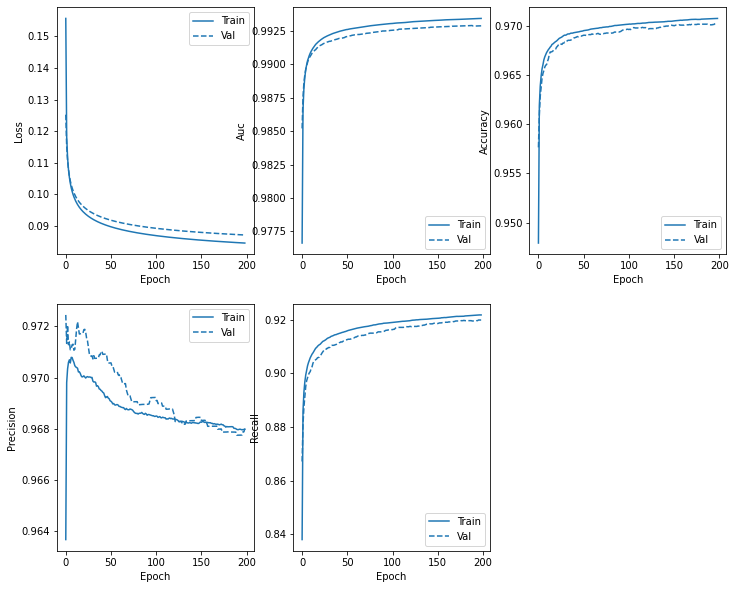

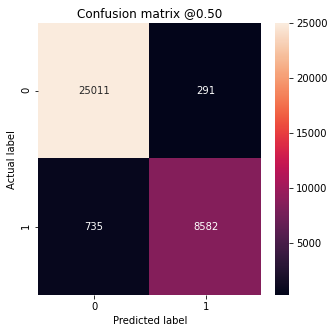

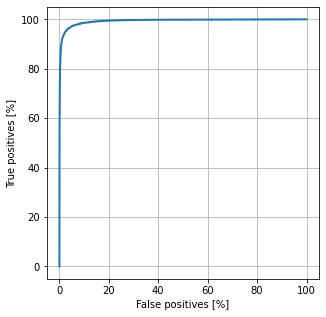

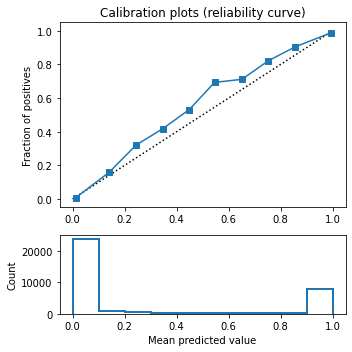

In [ ]:
# Fit model
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches,
    verbose=0,
    callbacks = [early_stopping])

# Save model
baseline_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN baseline/'
model.save_weights(baseline_savepath)

loss :  0.08465933054685593
accuracy :  0.9701319932937622
precision :  0.9674906730651855
recall :  0.9199312925338745
auc :  0.9937174916267395
tp :  59997.0
fp :  2016.0
tn :  175098.0
fn :  5222.0
ROC (AUC): 0.95427
brier: 0.023
Legitimate Transactions Detected (True Negatives):  25014
Legitimate Transactions Incorrectly Detected (False Positives):  288
Fraudulent Transactions Missed (False Negatives):  746
Fraudulent Transactions Detected (True Positives):  8571
Total Fraudulent Transactions:  9317


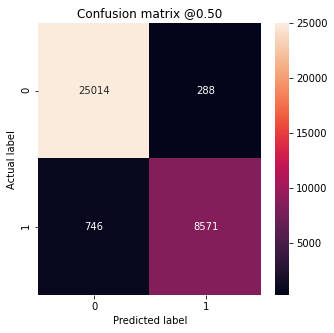

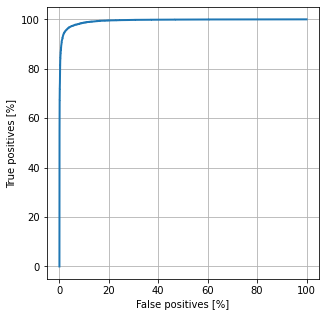

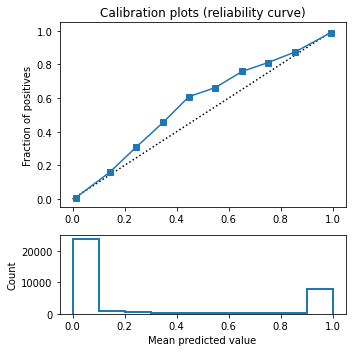

In [ ]:
# Load model again
model = make_model()
model.load_weights(baseline_savepath)

# Plot results
# plot_metrics(baseline_history)

baseline_results = model.evaluate(test_batches, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print("ROC (AUC): %1.5f" % roc_auc_score(ytest, test_predictions_baseline))

train_predictions_baseline = model.predict_classes(train_batches)
test_predictions_baseline = model.predict_classes(test_batches)
test_probabilities_baseline = model.predict(test_batches)
brier_score = brier_score_loss(ytest, test_probabilities_baseline)
print("brier: %1.3f" % (brier_score))

plot_cm(ytest, test_predictions_baseline)
plt.show()

plot_roc(ytest, test_probabilities_baseline)
plt.show()

plot_calibration_curve(ytest, test_probabilities_baseline)

### Model with class weight

Weight for class 0: 0.68
Weight for class 1: 1.86
loss :  0.09593097120523453
accuracy :  0.9696120619773865
precision :  0.9349542260169983
recall :  0.953418493270874
auc :  0.99376380443573
tp :  8883.0
fp :  618.0
tn :  24684.0
fn :  434.0
brier: 0.024
Legitimate Transactions Detected (True Negatives):  24684
Legitimate Transactions Incorrectly Detected (False Positives):  618
Fraudulent Transactions Missed (False Negatives):  434
Fraudulent Transactions Detected (True Positives):  8883
Total Fraudulent Transactions:  9317


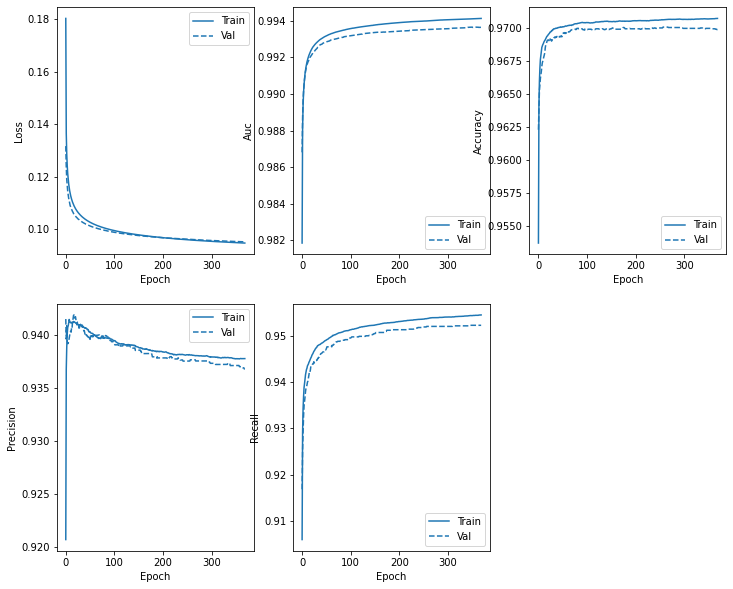

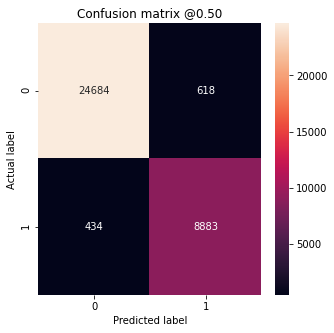

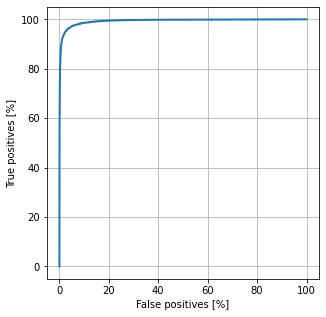

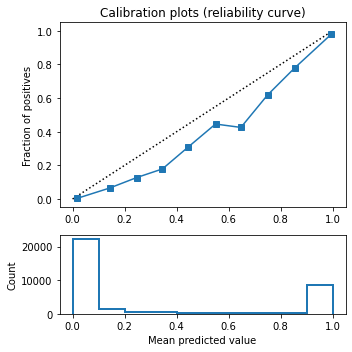

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

# Fit model
weighted_history = weighted_model.fit(
    train_batches,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=val_batches,
    # The class weights go here
    class_weight=class_weight,
    verbose = 0) 

# Save model
weighted_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN weighted/'
model.save_weights(weighted_savepath)

# Load model again
model = make_model()
model.load_weights(weighted_savepath)

# Plot results
plot_metrics(weighted_history)

weighted_results = weighted_model.evaluate(test_batches, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)

train_predictions_weighted = weighted_model.predict_classes(train_batches)
test_predictions_weighted = weighted_model.predict_classes(test_batches)
test_probabilities_weighted = weighted_model.predict(test_batches)
brier_score_weighted = brier_score_loss(ytest, test_probabilities_weighted)
print("brier: %1.3f" % (brier_score_weighted))

plot_cm(ytest, test_predictions_weighted)
plt.show()

plot_roc(ytest, test_probabilities_baseline)

plot_calibration_curve(ytest, test_probabilities_weighted)

### Model with over-sampling

In [ ]:
xtrain = scaler.fit_transform(xtrain)

pos_features = xtrain[bool_train_labels]
neg_features = xtrain[~bool_train_labels]

pos_labels = ytrain[bool_train_labels]
neg_labels = ytrain[~bool_train_labels]

BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.shuffle(buffer_size=1024).batch(batch_size)

resampled_steps_per_epoch = np.ceil(2.0*neg/batch_size)

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

# Fit model
resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_batches)

# Save model
resampled_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN resampled/'
model.save_weights(resampled_savepath)

loss :  0.09187471121549606
accuracy :  0.9688610434532166
precision :  0.9305047392845154
recall :  0.9556724429130554
auc :  0.994101345539093
tp :  8904.0
fp :  665.0
tn :  24637.0
fn :  413.0
brier: 0.024
Legitimate Transactions Detected (True Negatives):  24637
Legitimate Transactions Incorrectly Detected (False Positives):  665
Fraudulent Transactions Missed (False Negatives):  413
Fraudulent Transactions Detected (True Positives):  8904
Total Fraudulent Transactions:  9317


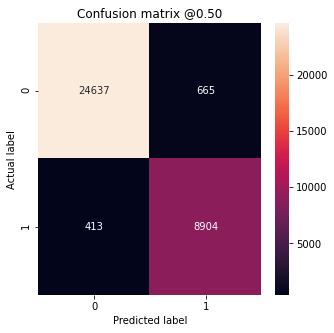

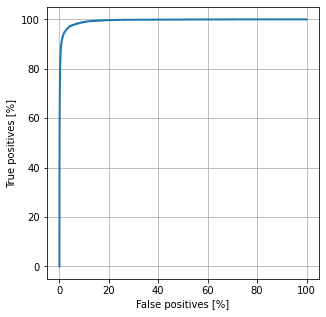

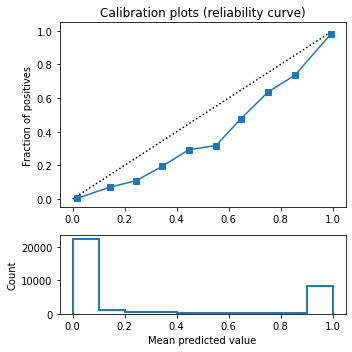

In [ ]:
# Load model again
model = make_model()
model.load_weights(resampled_savepath)

# Plot results
# plot_metrics(resampled_history)

resampled_results = resampled_model.evaluate(test_batches, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)

train_predictions_resampled = resampled_model.predict_classes(train_batches)
test_predictions_resampled = resampled_model.predict_classes(test_batches)
test_probabilities_resampled = resampled_model.predict(test_batches)
brier_score_resampled = brier_score_loss(ytest, test_probabilities_resampled)
print("brier: %1.3f" % (brier_score_resampled))

plot_cm(ytest, test_predictions_resampled)
plt.show()

plot_roc(ytest, test_probabilities_resampled)

plot_calibration_curve(ytest, test_probabilities_resampled)

### Test KFold

In [ ]:
# Keep a 10% holdout
#split train and holdout test sets
trainval, test = train_test_split(df.drop('pin', axis =1), test_size=0.1)

ytrainval = np.array(trainval.pop('dead'))
bool_train_labels = ytrainval != 0
ytest = np.array(test.pop('dead'))

scaler = StandardScaler()

xtrainval = scaler.fit_transform(np.array(trainval))
xtest = scaler.fit_transform(np.array(test))

print("xtrainval.shape:", xtrainval.shape, ", ytrainval.shape:", ytrainval.shape)
print("xtest.shape:", xtest.shape, ", ytest.shape:", ytest.shape)

# #construct pipelines
# trainval_set = tf.data.Dataset.from_tensor_slices((xtrainval, ytrainval))
# test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

# #batch the sets according to batch_size
# batch_size = 64
# trainval_batches = trainval_set.shuffle(buffer_size=1024).batch(batch_size)
# test_batches = test_set.batch(batch_size)

# Set KFold
kf = StratifiedKFold(3, shuffle=True, random_state=42) 
    
oos_yval = []
oos_ypred = []
oos_yprob
fold = 0

# Must specify y StratifiedKFold for
for train, val in kf.split(xtrainval, ytrainval):
    fold+=1
    print(f"Fold #{fold}")
        
    xtrain = x[train]
    ytrain = y[train]
    xval = x[val]
    yval = y[val]
    
    # Define ES callback to stop training when val_auc peaks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
                                                      patience=10, mode='max', restore_best_weights=True)
    
    # Define CP callback to save model with best val_auc
    checkpoint_path = f'./Medicare Analysis/Data/model/Fold #{fold}'
    os.mkdir(checkpoint_path)
    check_point = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                     monitor='val_auc', mode='max', save_best_only=True)
    
    # Train model
    model = make_model()
    model.load_weights(initial_weights)
    model.fit(xtrain, ytrain, validation_data=(xval, yval), verbose=0, epochs = EPOCHS, 
              callbacks = [early_stopping, check_point])
    
    # Load model with best val_auc
    model = make_model()
    model.load_weights(checkpoint_path)
    yprob = model.predict(xval)
    ypred = model.predict_classes(xval)) 

    oos_yval.append(yval)
    oos_yprob.append(yprob)
    oos_ypred.append(ypred)  

    # Measure this fold's accuracy
    score = metrics.accuracy_score(yval, pred)
    print(f"Fold #{fold} score (accuracy): {score}")
    
# Build the oos prediction list and calculate the error.
oos_yval = np.concatenate(oos_yval)
oos_yprob = np.concatenate(oos_yprob)
oos_ypred = np.concatenate(oos_ypred)

plot_cm(oos_yval, oos_ypred)
score = accuracy_score(oos_yval, oos_ypred)
print(f"Stratified KFold CV accuracy: {score}")    
plot_roc('Stratified KFold CV', oos_yval, oos_ypred):
plot_calibration_curve(oos_yval, oos_yprob)

# Write the cross-validated prediction
oos_ytest = pd.DataFrame(oos_ytest)
oos_ypred = pd.DataFrame(oos_ypred)
oosDF = pd.concat([df, oos_ytest, oos_ypred], axis=1)

In [ ]:
# Choose model with best val_auc to evaluate
model = make_model()
model.load_weights(#checkpoint_path to the best fold model#) ...